# Logistic Regression Classifier

The logistic regression model computes the probability of malignancy as:

$$P(y = 1|x) = \sigma(w^T x + b)$$

Where:
* $x$ is the feature vector.
* $w$ is a vector with coefficients for each feature.
* $b$ is the bias.
* $\sigma$ is the logistic or sigmoid function.

We read the dataset from file `wdbc.pkl` and select the quantitative features. We divide the dataset in a distribution of 60% training, 20% validation and 20% testing with stratification to maintain class distribution.

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_pickle("wdbc.pkl")

features = ['radius_0', 'area_0', 'perimeter_0', 'radius_1', 'area_1', 'perimeter_1', 'radius_2', 'perimeter_2', 'area_2',
            'concavity_0', 'concave points_0', 'compactness_0', 'concavity_1', 'concave points_1', 'concavity_2', 'concave points_2', 'compactness_2',
            'texture_0', 'smoothness_0', 'texture_1', 'smoothness_1', 'texture_2', 'smoothness_2',
            'fractal dimension_0', 'fractal dimension_1', 'fractal dimension_2',
            'symmetry_0', 'symmetry_1', 'symmetry_2']

X = df[features].values
y = df['malignant'].values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

Because logistic regression is sensitive to scale, all variables must be standardized using the training data. The scaler must be fitted only in training set and then applied to validation and test sets to prevent data leakage.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

The Logistic Regression classifier utilizes regularization to prevent overfitting. By default, Scikit-Learn applies L2 regularization, which penalizes the magnitude of the coefficients.

### The Objective Function
The goal of the model is to minimize the following cost function:

$$J(w) = \text{Loss} + \lambda \|w\|^2$$

Where:
*   **$\text{Loss}$**: Represents the Categorical Cross-Entropy (Log Loss).
*   **$\lambda$**: The regularization strength.
*   **$\|w\|^2$**: The L2 norm of the weight vector.

In Scikit-Learn implementation, regularization strength is controlled by the parameter **$C$**, defined as:

$$C = \frac{1}{\lambda}$$

*   Small $C$ values: Provide **strong regularization**, shrinking the weights $w$ closer to zero.
*   Large $C$ values: Provide **weak regularization**, allowing the model more flexibility to fit the data.

After conducting a search within the logarithmic range $[10^{-2}, 10^2]$ and prioritizing recall for the malignant class, the results are $C\approx 0.4832$. In medical diagnostics, maximizing recall is critical to minimize false negatives, ensuring that as many malignant cases as possible are correctly identified.

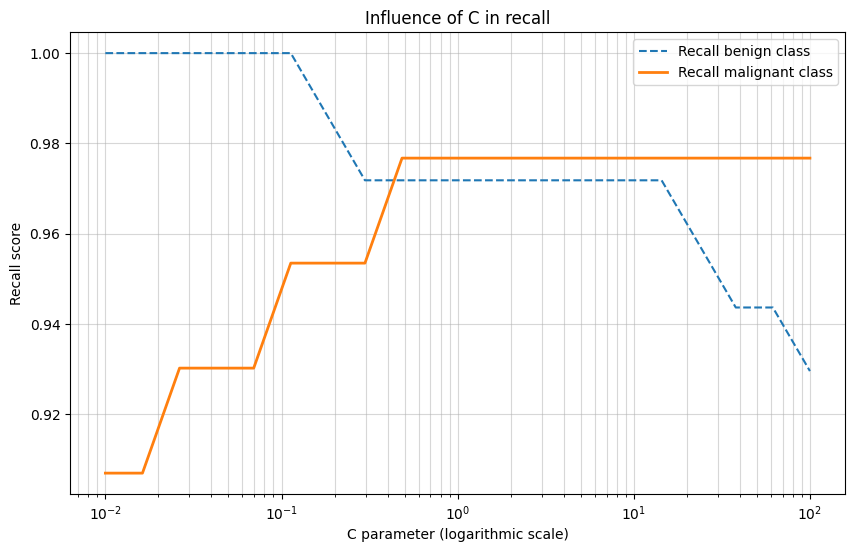

In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt 

cs = np.logspace(-2,2,20)
recalls0 = []
recalls1 = []

for C in cs:
    model = LogisticRegression(C=C, max_iter=500)
    model.fit(X_train_scaled, y_train)
    y_predv = model.predict(X_val_scaled)
    recall = recall_score(y_val, y_predv, pos_label=1)
    recalls0.append(recall_score(y_val, y_predv, pos_label=0))
    recalls1.append(recall_score(y_val, y_predv, pos_label=1))
    #     print(f"\n=== k = {k} ===")
    #     print(classification_report(y_val, pred_val))

plt.figure(figsize=(10, 6))
plt.plot(cs, recalls0, label='Recall benign class', linestyle='--')
plt.plot(cs, recalls1, label='Recall malignant class', linewidth=2)
plt.xscale('log')
plt.title('Influence of C in recall')
plt.xlabel('C parameter (logarithmic scale)')
plt.ylabel('Recall score')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

The classification report for this $C$ value is the following:

In [17]:
from sklearn.metrics import classification_report

C = 0.4832
model = LogisticRegression(C=C, max_iter=500)
model.fit(X_train_scaled, y_train)
y_predv = model.predict(X_val_scaled)
print(classification_report(y_val, y_predv))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



With this parameter, we can train the model with both training and validation sets and analyze which variables have more impact in the model.

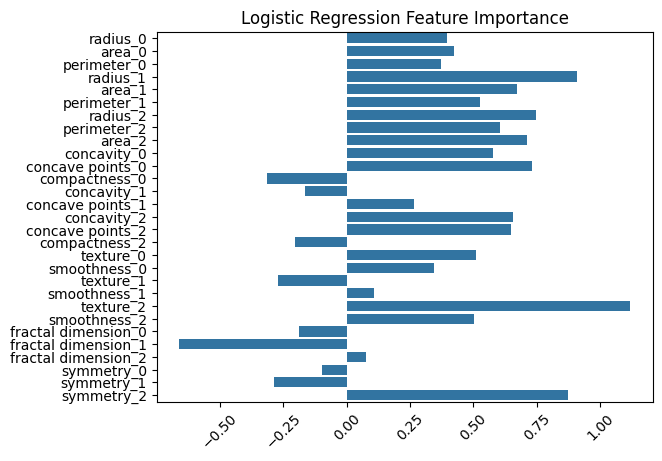

In [18]:
import seaborn as sns

X_trainval = np.vstack([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

final_model = LogisticRegression(C=C, max_iter=500)
final_model.fit(X_trainval, y_trainval)
y_pred = final_model.predict(X_test_scaled)

sns.barplot(x=final_model.coef_[0], y=features)
plt.xticks(rotation=45)
plt.title("Logistic Regression Feature Importance")
plt.show()


We can visualize the coefficients for each feature and therefore state which features are more important for this classification.

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



The confusion matrix of the classifications is the following:

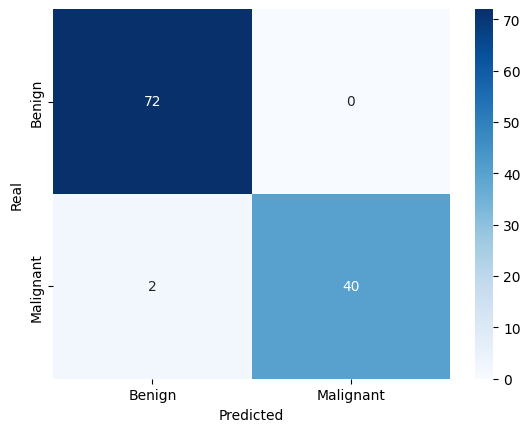

In [20]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign","Malignant"], yticklabels=["Benign","Malignant"])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

Finally, the ROC Curve has really good values, since there are only 2 false negatives and 0 false positives.

0.9973544973544973


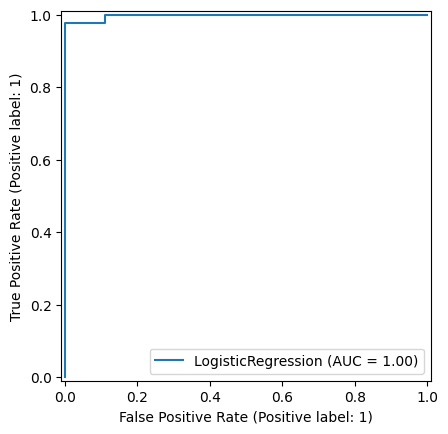

In [21]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_prob = final_model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(auc)
RocCurveDisplay.from_estimator(final_model, X_test_scaled, y_test)
plt.show()